# <center > PHYC90009 Assignment </center>
## <center> How much of the sky is covered by galaxies? </center> 

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Packages 
Numpy, Scipy, Matplotlib

In [15]:
import numpy as np
import scipy as sp
from scipy.integrate import quad, dblquad, simps 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
plt.rcParams['figure.dpi'] = 100

## Constants 
### Speed of Light m s-1
$$c = 299792458 $$
### Reduced Hubble Const
$$h = 0.7$$ 
### Omega for Curvature
$$\Omega_k = 0 $$
### Omega Matter
$$\Omega_m = 0.3$$ 
### Omega Dark Energy
$$\Omega_\lambda = 0.7$$ 
### Omega Radiation
$$\Omega_r = 0.0$$
### Spectral Index
$$n = 1$$ 
### Variance at 8 MPC
$$\sigma_8 = 0.9$$
### Gravitational Constant
$$G = 6.67e-11$$

In [16]:
h_0 = 67.66 #Hubble Const from Planck km s-1 Mpc-1
c = 299792458 #Speed of Light m s-1
h = 0.7 #Reduced Hubble Const
om_k = 0 #Omega for Curvature
om_m = 0.3 #Omega Matter
om_lam = 0.7 #Omega Dark Energy
om_r = 0.0 #Omega Radiation
n = 1 
sig_8 = 0.9
G = 6.67e-11 # m3 kg-1 s-2
d_h0 = c*10**(-3)/h_0 # Hubble dist at current time 


### 1) a) Compute and Plot the Angular Diamter Distance as a Function of Redshift
Angular Diamter Distance $d_A$ is given 
$$ d_A = \frac{r_{em}}{1 + z}$$
Where $r_{em}$ is the comoving distance, given by 
$$ r_{em} = \int_0^z d_h dz' $$ 
z is redshift,
d_h is the Hubble Distance, given by 
$$ d_h = \frac{c}{H(z)} $$
$$ \Rightarrow d_A = \frac{c}{1+z} \int_0^z \frac{dz'}{H(z)} $$

In [17]:
z = np.arange(0,10,0.1)
def d_h(z):
    return(c/(h_0*np.sqrt(om_m*(1+z)**3 + om_lam)))

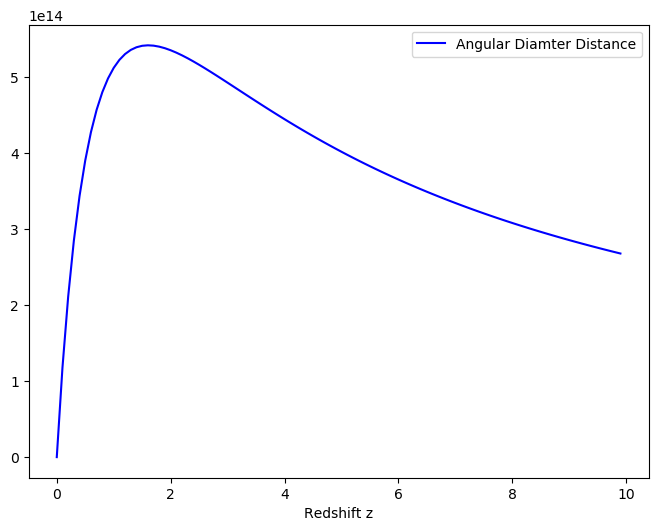

In [18]:
r_em = [(c/(1+zed)*quad(d_h,0,zed)[0]) for zed in z]
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(z,r_em,'b-',label='Angular Diamter Distance')
ax.set_xlabel('Redshift z')
ax.legend(loc = 'upper right')

### 1) b) Compute and Plot the Growth Function as a Function of Redshift
The growth function as a function of redshift is given by 
$$ D(t) \propto \frac{(\Omega_\Lambda a^3 + \Omega_k a + \Omega_m)^{1/2}}{a^{3/2}} \int_0^a \frac{a'^{3/2} da'}{(\Omega_\Lambda a'^3 + \Omega_k a' + \Omega_m)^{3/2}} $$ 
where $a = \frac{1}{1+z}$

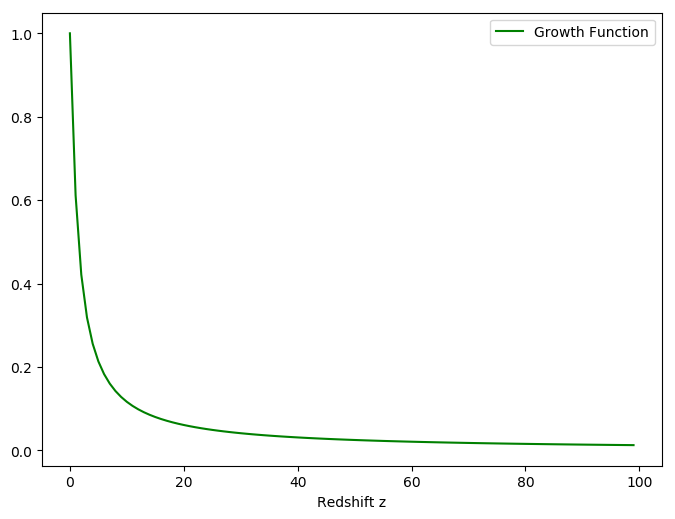

In [19]:
z = np.arange(0,100,1)
a = 1/(1+z)
# Need to Change Variables to get right results
def temp_func(a):
    return(float((a**(3./2.))/((om_lam * a**3 + om_k * a + om_m )**(3./2.))))

D_t = [np.sqrt(om_lam * ay**3 + om_k * ay + om_m )/(ay**(3/2))*quad(temp_func,0,ay)[0] for ay in a]

# Normalise D_t using z=1
D_t_norm = np.sqrt(om_lam * 1**3 + om_k * 1 + om_m )/(1**(3/2))*quad(temp_func,0,1)[0] 

D_t = D_t/D_t_norm

fig, ax = plt.subplots(figsize= (8,6))
ax.plot(z,D_t,'g-',label='Growth Function')
ax.set_xlabel('Redshift z')
ax.legend(loc = 'upper right')

## 1) c) Compute and plot the variance on a mass scale $M$ at redshift $z$
The variance of the Mass Scale is given by the expression
$$\sigma^2 (m) = \sigma^2 (R) = \frac{1}{2 \pi^2} \int_0^\infty dk k^2 P(k) \Bigg[ \frac{3 j_1(kR) }{kR} \Bigg]^2$$
Where
$$ j_1 = \frac{\sin(x) - x \cos(x) }{x^2} $$
$$ P(k) \propto k^n T^2(k) $$ 
$$ T(k) = \frac{\ln(1+2.34q)}{2.34 q} [1+3.89q+(16.1q)^2 + (5.46q)^3 + (6.71q)^4]^{-1/4} $$
$$ q = \frac{k}{\Omega_m^z h^2} $$
$$ \Omega_m^z = \frac{\Omega_m (1+z)^3}{\Omega_m (1+z)^3 + \Omega_{\Lambda} + \Omega_k(1+z)^2}$$

Therefore, the sub-factors must be calculated first, and passed through the functions in a bootstrap fashion. We also have to note that 
$$ M = \frac{4 \pi R^3 \rho_M}{3} \Rightarrow R = \Big(\frac{3 M}{4 \pi \rho_M}\Big)^{1/3}$$
All of these terms have to be calculated at $z=0$, and we evolve them to higher redshifts using the growth factor $D$

In [20]:
# Density in Solar Masses per megaparsec^3
rho_crit = (3*(h_0*3.241e-20)**2)/(8*np.pi*G*6.769e-38)
rho_m = om_m*rho_crit
#Generate Mass Space
m = np.logspace(2,15,num=1000)
#Convert to Radius (Units = Mpc)
r = ((3*m)/(4*np.pi*rho_m))**(1/3)


In [21]:
def j_1(x):
    return((np.sin(x) - x* np.cos(x))/(x**2))

def q(k):
    return(k/(om_m*h**2))

def t_k(k):
    first = (np.log(1+2.34*q(k))/(2.34*q(k)))
    second = (1+3.89*q(k) + (16.1*q(k))**2 + (5.46*q(k))**3 + (6.71*q(k))**4)**(-1/4)
    return( first*second )

def P_k(k):
    return(((k * (t_k(k))**2)))

def integrand(k,r):
    return(k**2 * P_k(k) * ((3 * j_1(k*r))/(k*r))**2)

sigma_8_int = (1/(2*np.pi**2)*quad(integrand,0,np.inf,args=(8/h))[0])**(1/2)
#print(sigma_8_int)
const_s8 = 0.9/sigma_8_int
#print(const_s8)

#Perform Integral over k, passing radii to function as you go
var_z_0 = [(const_s8*(1/(2*np.pi**2)*quad(integrand,0,np.inf,args=(ar))[0])**(1/2)) for ar in r]

#Scale at higher redshifts using Growth Factor
var_z_5 = [zed*D_t[5] for zed in var_z_0]
var_z_10 = [zed*D_t[10] for zed in var_z_0]
var_z_20 = [zed*D_t[20] for zed in var_z_0]
var_z_30 = [zed*D_t[30] for zed in var_z_0]



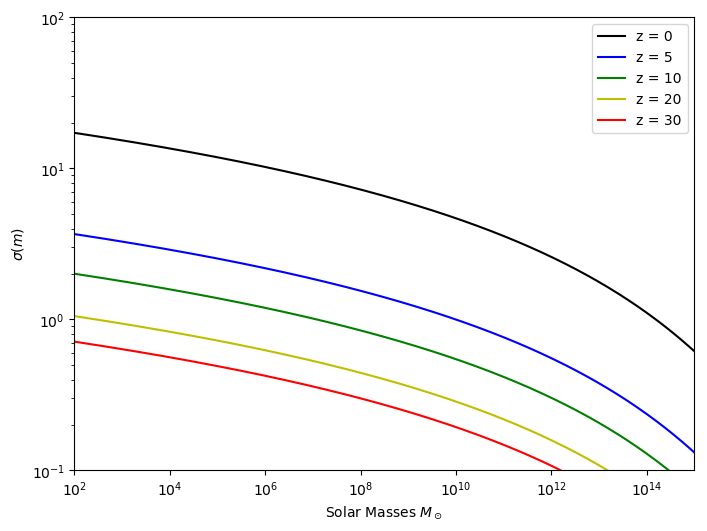

In [22]:
fig, ax = plt.subplots(figsize= (8,6))
plt.ylim(0.1,100)
ax.semilogx(m,var_z_0,'k-',label='z = 0')
ax.semilogx(m,var_z_5,'b-',label='z = 5')
ax.semilogx(m,var_z_10,'g-',label='z = 10')
ax.semilogx(m,var_z_20,'y-',label='z = 20')
ax.semilogx(m,var_z_30,'r-',label='z = 30')
#ax.plot(m,z_5,'r-',label='z = 5')
#ax.plot(k[:500],integrand(k,10,1)[:500],'b-')
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc = 'upper right')
ax.set_xlabel('Solar Masses $M_\odot$')
ax.set_ylabel('$\sigma(m)$')
ax.margins(x=0)


## 1) d) the Press - Schechter mass function of DM halos (at a range of redshifts)
The Press-Schechter Mass Function is given by 
$$\frac{d n_h (m,z)}{dm} = - \sqrt{\frac{2}{\pi}} \frac{\rho_m}{m} \frac{d[\log{\sigma(m)}]}{dm} \nu_c \exp\Big(-\frac{\nu_c^2}{2} \Big)$$
Where 
$$\nu_c = \delta_c (z) \sigma(m) $$
Again, $\sigma(m)$, and $\rho_m$ are calculated at $z=0$

We know that $\delta_c(z=0) = 1.69$, and we can evolve the critical density backwards using the growth factor
$$ \delta_c(z) = \frac{1.69}{D(z)}$$
We can also approximate the derivative term 
$$\frac{d[\log{\sigma(m)}]}{dm} \approx \frac{\log\sigma(m+\Delta m) - \log\sigma(m)}{\Delta m} \approx \frac{\ln\sigma(1.1m) - \ln\sigma(m)}{1.1m-m}$$ 

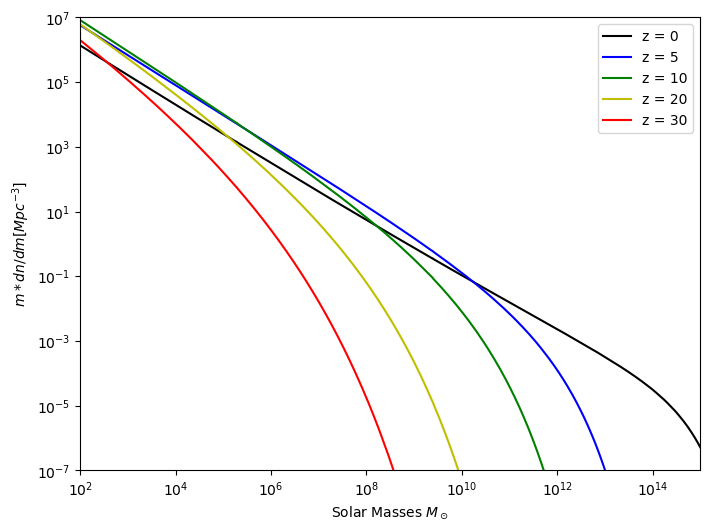

In [23]:
def d_c(z): 
    return(1.69/D_t[z])
#Initialise variational term for mass, and generate second set of R values
second_m = 1.1*m
second_r  = ((3*second_m)/(4*np.pi*rho_m))**(1/3)
#Calcualte variance at 1.1m 
var_z_0_1pt1 = [(const_s8*(1/(2*np.pi**2)*quad(integrand,0,np.inf,args=(ar))[0])**(1/2)) for ar in second_r]
#Compute Differential Term
diff_term = (np.log(var_z_0_1pt1) - np.log(var_z_0))/(second_m-m)

#Compute the Nu values for various redshifts
nu_z0 = d_c(0)/var_z_0
nu_z5 = d_c(5)/var_z_0
nu_z10 = d_c(10)/var_z_0
nu_z20 = d_c(20)/var_z_0
nu_z30 = d_c(30)/var_z_0

#Compute the ratio of masses 
#Likely Unit problems
dn_dm_z0 = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z0* np.exp(- (nu_z0)**2/2)
dn_dm_z5 = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z5* np.exp(- (nu_z5)**2/2)
dn_dm_z10 = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z10* np.exp(- (nu_z10)**2/2)
dn_dm_z20 = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z20* np.exp(- (nu_z20)**2/2)
dn_dm_z30 = -np.sqrt((2)/(np.pi))* rho_m/(m) * diff_term * nu_z30* np.exp(- (nu_z30)**2/2)



fig, ax = plt.subplots(figsize= (8,6))
plt.ylim(1e-7,1e7)
ax.semilogx(m,m*dn_dm_z0,'k-',label='z = 0')
ax.semilogx(m,m*dn_dm_z5,'b-',label='z = 5')
ax.semilogx(m,m*dn_dm_z10,'g-',label='z = 10')
ax.semilogx(m,m*dn_dm_z20,'y-',label='z = 20')
ax.semilogx(m,m*dn_dm_z30,'r-',label='z = 30')
ax.set_yscale("log")
ax.legend(loc = 'upper right')
ax.set_xlabel('Solar Masses $M_\odot$')
ax.set_ylabel('$m*dn/dm [Mpc^{-3}]$')
ax.margins(x=0)


## 2) a) For halos of mass $M$ at redshift $z$ calculate and plot the virial radius of dark matter halos, and the radius of a galaxy disk

In order to calculate this, we need to utilise
$$d = \Omega_m^z - 1 $$
$$\Delta_c = 18\pi^2 + 82 d - 39d^2 $$
$$ r_{vir} = 0.784 \Big( \frac{M}{10^{8} h^{-1} M_{\odot}} \Big)^{1/3} \Big[ \frac{\Omega_m}{\Omega_m^z} \frac{\Delta_c}{18\pi^2} \Big] \Big( \frac{1+z}{10} \Big)^{-1} h^{-1} \text{kpc} $$

$$ V_c = \Big(\frac{G M }{r_{vir}}\Big)^{1/2} $$

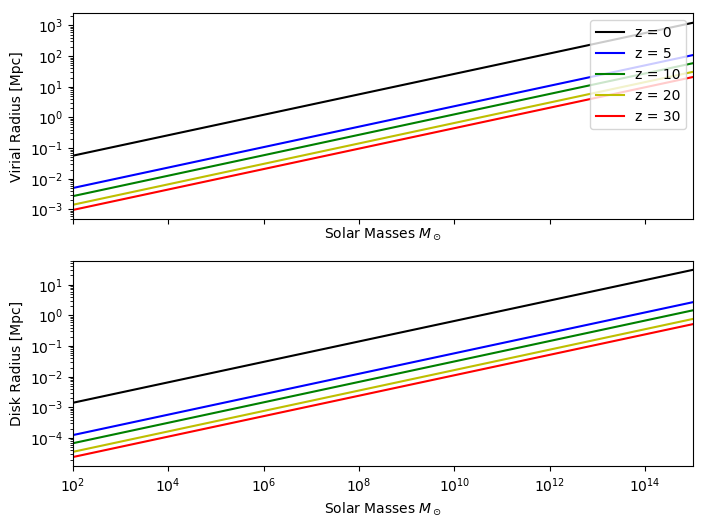

In [34]:
def om_m_z(z): 
    return((om_m * (1+z)**3)/((om_m * (1+z)**3) + om_lam + om_k * (1+z)**2))
def d(z):
    return(om_m_z(z) - 1)

def del_crit(z):
    return(18*np.pi**2 + 82 * d(z) - 39* d(z)**2)

def vir_r(M,z):
    mass_term = ((M)/(10**8 * h**(-1)))**(1/3)
    density_term = (om_m * del_crit(z))/(om_m_z(z) * 18 * np.pi**2)
    redshift_term = ((1+z)/10)**(-1)
    return(0.784*mass_term*density_term*redshift_term*h**(-1))

def vel_crit(M,z):
    return(((G*6.769e-38*M)/vir_r(M,z))**(1/2))

vir_r_z0 = [vir_r(em,0) for em in m]
vir_r_z5 = [vir_r(em,5) for em in m]
vir_r_z10 = [vir_r(em,10) for em in m]
vir_r_z20 = [vir_r(em,20) for em in m]
vir_r_z30 = [vir_r(em,30) for em in m]

disk_r_z0 = [r/40. for r in vir_r_z0]
disk_r_z5 = [r/40. for r in vir_r_z5]
disk_r_z10 = [r/40. for r in vir_r_z10]
disk_r_z20 = [r/40. for r in vir_r_z20]
disk_r_z30 = [r/40. for r in vir_r_z30]


fig, (ax1, ax2) = plt.subplots(2,1,figsize= (8,6),sharex=True)
ax1.semilogx(m,vir_r_z0,'k-',label='z = 0')
ax1.semilogx(m,vir_r_z5,'b-',label='z = 5')
ax1.semilogx(m,vir_r_z10,'g-',label='z = 10')
ax1.semilogx(m,vir_r_z20,'y-',label='z = 20')
ax1.semilogx(m,vir_r_z30,'r-',label='z = 30')
ax1.set_yscale("log")
ax1.legend(loc = 'upper right')
ax1.set_xlabel('Solar Masses $M_\odot$')
ax1.set_ylabel('Virial Radius [Mpc]')
ax1.margins(x=0)

ax2.semilogx(m,disk_r_z0,'k-',label='z = 0')
ax2.semilogx(m,disk_r_z5,'b-',label='z = 5')
ax2.semilogx(m,disk_r_z10,'g-',label='z = 10')
ax2.semilogx(m,disk_r_z20,'y-',label='z = 20')
ax2.semilogx(m,disk_r_z30,'r-',label='z = 30')
ax2.set_yscale("log")
ax2.set_xlabel('Solar Masses $M_\odot$')
ax2.set_ylabel('Disk Radius [Mpc]')
ax2.margins(x=0)



In [12]:
x = np.linspace(0,np.pi,1000)

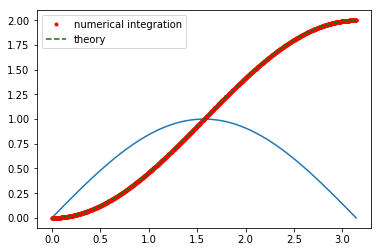

In [13]:
fig, ax = plt.subplots()
ax.plot(x,np.sin(x))
results = np.empty(len(x))

#for ii, xi in enumerate(x):
    
#    results[ii] = quad(np.sin,0,xi)[0]

results = [quad(np.sin,0,xi)[0] for xi in x]
ax.plot(x,results,'r.',label = 'numerical integration')
ax.plot(x,1-np.cos(x), 'g--',label = 'theory')

ax.legend(loc = 'upper left')

In [14]:
quad(np.sin,0,1.2)

(0.6376422455233265, 7.079251024536842e-15)